In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.pandas.set_option('display.max_columns',None)

In [3]:
train_data = pd.read_csv("../data/train_processed_data.csv")
train_data.shape

(39980, 18)

In [34]:
from sklearn.model_selection import train_test_split, GridSearchCV,  KFold
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, plot_roc_curve , plot_precision_recall_curve
from numpy import sqrt
from numpy import argmax
from matplotlib import pyplot

In [5]:
from sklearn import metrics
def model_compare(model_name,model,y_test,y_pred, roc_auc = None):
    y_score = accuracy_score(y_test, y_pred)
    if roc_auc:
        fpr_dt, tpr_dt, _ = roc_curve(y_test, y_pred)
        roc_auc = auc(fpr_dt, tpr_dt) 
    binclass_metrics = {
                        'Accuracy' : metrics.accuracy_score(y_test, y_pred),
                        'Precision': metrics.precision_score(y_test, y_pred),
                        'Recall'   : metrics.recall_score(y_test, y_pred),
                        'F1 Score' : metrics.f1_score(y_test, y_pred),
                        'ROC AUC'  : roc_auc
                       }

    df_metrics = pd.DataFrame.from_dict(binclass_metrics, orient='index')
    df_metrics.columns = [model_name] 
    return df_metrics

In [6]:
def selecting_optimal_thresholds(model,x_test,y_test):
    model_probs = model.predict_proba(x_test)
    model_probs = model_probs[:, 1]
    model_auc   = roc_auc_score(y_test, model_probs)

    fpr, tpr, thresholds = roc_curve(y_test, model_probs)

    gmeans = sqrt(tpr * (1-fpr))
    
    ix = argmax(gmeans)
    # ix = 25
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))

    # plot the roc curve for the model
    pyplot.plot([0,1], [0,1], linestyle='--', label='No Skill')
    pyplot.plot(fpr, tpr, marker='.', label='Logistic')
    pyplot.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')
    pyplot.legend()
    # show the plot
    pyplot.show()
    
    precision, recall, thresholds = precision_recall_curve(y_test, model_probs)
    # convert to f score
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = argmax(fscore)
    print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
    
    # plot the roc curve for the model
    no_skill = len(y_test[y_test==1]) / len(y_test)
    pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    pyplot.plot(recall, precision, marker='.', label='Logistic')
    pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')
    pyplot.legend()
    # show the plot
    pyplot.show()

In [7]:

def draw_confusion_matrix_binary(y_test,y_pred,model=None):
    matrixdata = confusion_matrix(y_test, y_pred, labels=[1,0])
    print(matrixdata)
    group_names  = ['TP','FN','FP','TN'] # ['TN','FP','FN','TP']
    group_counts = ["{0:0.0f}".format(value) for value in
                matrixdata.flatten()]
    categories = ['Zero', 'One']
    labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(matrixdata, annot=labels, cmap='Blues' , fmt='',xticklabels=[1,0], yticklabels=[1,0]) # cmap='Blues' , fmt=''   categories=categories,cmap='binary'
    
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.title('Actual vs. Predicted Confusion Matrix')
    plt.show()
    
    print(f" TPR  => {matrixdata[0][0]/(matrixdata[0][0] + matrixdata[0][1])} \n")
    print(f" FPR  => {(1 - (matrixdata[1][1]/(matrixdata[1][0] + matrixdata[1][1])))} \n")
    print(classification_report(y_test, y_pred, labels=[1,0]))

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [9]:
x = train_data.drop(['y'],axis =1).values
scaler.fit(x)
x = scaler.transform(x)
y = train_data['y'].values
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size =0.3, random_state=303)

## DecisionTree

In [10]:
from sklearn.tree import DecisionTreeClassifier

In [13]:
model_dt = DecisionTreeClassifier(random_state=303)
np.random.seed(303)
# start = time.time()
param_dist = {'max_depth': [2, 3, 4, 5, 6, 7],
              'min_samples_leaf':[100,200,70, 30],
              'criterion': ['gini', 'entropy']}

cv_rf = GridSearchCV(model_dt, cv = 10,
                     param_grid=param_dist, 
                     n_jobs = 1)

cv_rf.fit(x_train, y_train)
print('Best Parameters using grid search: \n', cv_rf.best_params_)

Best Parameters using grid search: 
 {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 30}


In [11]:
model_dt = DecisionTreeClassifier(random_state=303,
                                  max_depth=6, 
                                  criterion = 'gini', 
                                  min_samples_leaf=30 )
model_dt.fit(x_train, y_train)
model_dt_score_train = model_dt.score(x_train, y_train)
print("Training score: ",model_dt_score_train)
model_dt_score_test = model_dt.score(x_test, y_test)
print("Testing score: ",model_dt_score_test)

Training score:  0.9264989637675981
Testing score:  0.9187093546773387


[[  596   600]
 [  375 10423]]


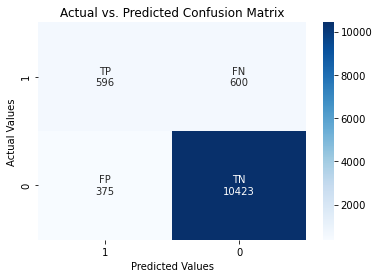

 TPR  => 0.4983277591973244 

 FPR  => 0.034728653454343394 

              precision    recall  f1-score   support

           1       0.61      0.50      0.55      1196
           0       0.95      0.97      0.96     10798

    accuracy                           0.92     11994
   macro avg       0.78      0.73      0.75     11994
weighted avg       0.91      0.92      0.91     11994



,Decision Tree
Accuracy,0.918709
Precision,0.613800
Recall,0.498328
F1 Score,0.550069
ROC AUC,0.731800


In [12]:
y_pred = model_dt.predict(x_test)
draw_confusion_matrix_binary(y_test,y_pred)
metrix_dt = model_compare("Decision Tree",model_dt, y_test, y_pred, True )
metrix_dt

In [13]:
np.mean(np.where((y_test==1)&(y_pred==1),1,0))*100

4.96915124228781

In [14]:
from yellowbrick.classifier import DiscriminationThreshold

### SELECTING OPTIMAL Thresholds

Best Threshold=0.115183, G-Mean=0.874


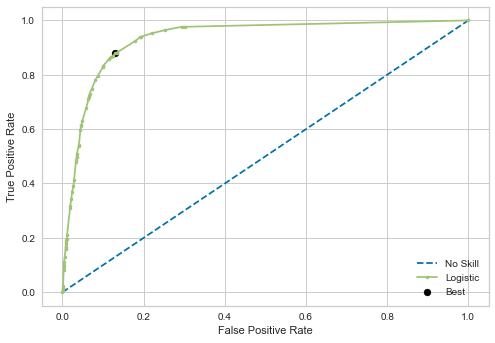

Best Threshold=0.324324, F-Score=0.626


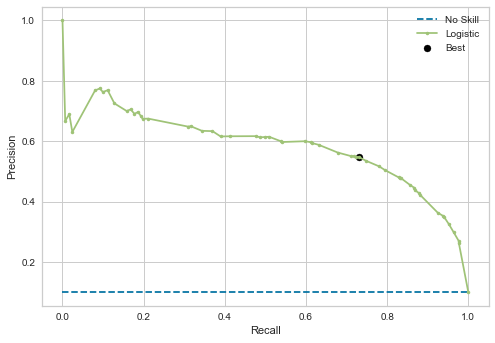

In [15]:
selecting_optimal_thresholds(model_dt,x_test,y_test)

[[1052  144]
 [1410 9388]]


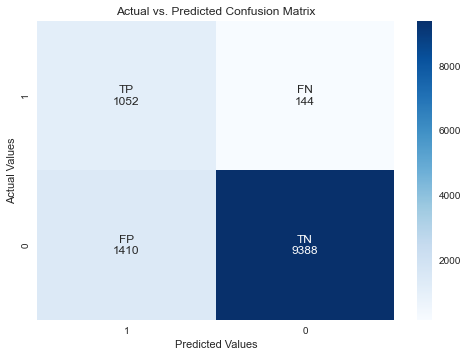

 TPR  => 0.8795986622073578 

 FPR  => 0.13057973698833114 

              precision    recall  f1-score   support

           1       0.43      0.88      0.58      1196
           0       0.98      0.87      0.92     10798

    accuracy                           0.87     11994
   macro avg       0.71      0.87      0.75     11994
weighted avg       0.93      0.87      0.89     11994



,Decision Tree ROC
Accuracy,0.870435
Precision,0.427295
Recall,0.879599
F1 Score,0.575178
ROC AUC,0.874509


In [28]:
y_pred = (model_dt.predict_proba(x_test)[:,1] >= 0.115183).astype(bool) 
draw_confusion_matrix_binary(y_test,y_pred)
roc_metrix_dt = model_compare("Decision Tree ROC ",model_dt, y_test, y_pred,True  )
roc_metrix_dt

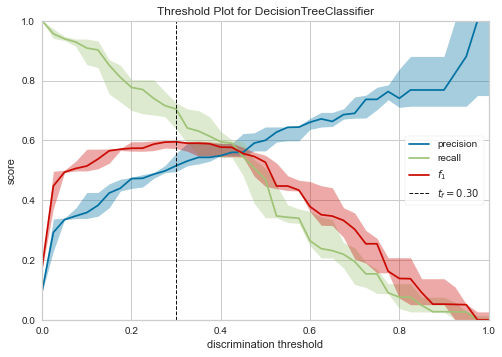

<AxesSubplot:title={'center':'Threshold Plot for DecisionTreeClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [42]:
visualizer = DiscriminationThreshold(model_dt,
                                     n_trials=5,
                                     cv=0.5,
                                     argmax='fscore',
                                     random_state=0,
                                     is_fitted=False,
                                     exclude = "queue_rate")

visualizer.fit(x_train, y_train)        # Fit the visualizer and the model
visualizer.score(x_test, y_test)        # Evaluate the model on the test data
visualizer.show()

[[  873   323]
 [  721 10077]]


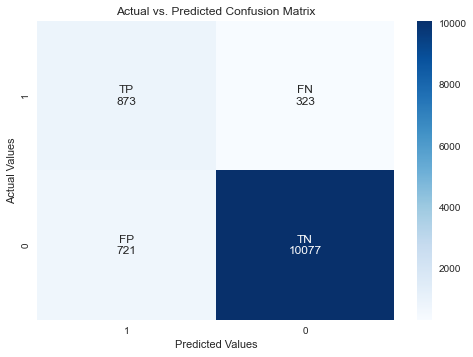

 TPR  => 0.729933110367893 

 FPR  => 0.06677162437488426 

              precision    recall  f1-score   support

           1       0.55      0.73      0.63      1196
           0       0.97      0.93      0.95     10798

    accuracy                           0.91     11994
   macro avg       0.76      0.83      0.79     11994
weighted avg       0.93      0.91      0.92     11994



,Decision Tree ROC
Accuracy,0.912956
Precision,0.547679
Recall,0.729933
F1 Score,0.625806
ROC AUC,0.831581


In [27]:
y_pred = (model_dt.predict_proba(x_test)[:,1] >= 0.3).astype(bool) 
draw_confusion_matrix_binary(y_test,y_pred)
fscore_metrix_dt = model_compare("Decision Tree ROC ",model_dt, y_test, y_pred,True  )
fscore_metrix_dt

In [18]:
metrix_dt

,Decision Tree
Accuracy,0.918709
Precision,0.613800
Recall,0.498328
F1 Score,0.550069
ROC AUC,0.731800


## Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

In [20]:
model_rf = RandomForestClassifier(random_state=303)

In [40]:
param_dist = {'max_depth': [3,4,5,7,8],
              'bootstrap': [True, False],
              'max_features': ['auto', 'sqrt', 'log2', None],
              'criterion': ['gini', 'entropy']}

cv_rf = GridSearchCV(model_rf, cv = 10,
                     param_grid=param_dist, 
                     n_jobs = 1)

cv_rf.fit(x_train, y_train)
print('Best Parameters using grid search: \n', cv_rf.best_params_)

Best Parameters using grid search: 
 {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 8, 'max_features': None}


In [21]:
model_rf.set_params(criterion    = 'entropy',
                    max_features = None, 
                    max_depth    = 8,
                    bootstrap    = True,
                    n_estimators = 1400,
                    warm_start   = False, 
                    oob_score    = False
                   )


RandomForestClassifier(criterion='entropy', max_depth=8, max_features=None,
                       n_estimators=1400, random_state=303)

[[  604   592]
 [  342 10456]]


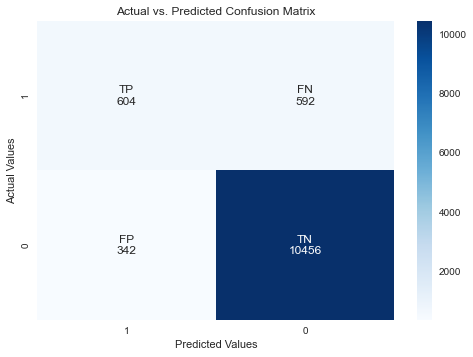

 TPR  => 0.5050167224080268 

 FPR  => 0.03167253195036113 

              precision    recall  f1-score   support

           1       0.64      0.51      0.56      1196
           0       0.95      0.97      0.96     10798

    accuracy                           0.92     11994
   macro avg       0.79      0.74      0.76     11994
weighted avg       0.92      0.92      0.92     11994



,Random Forest
Accuracy,0.922128
Precision,0.638478
Recall,0.505017
F1 Score,0.563959
ROC AUC,0.736672


In [22]:
model_rf.fit(x_train, y_train)
y_pred= model_rf.predict(x_test)
draw_confusion_matrix_binary(y_test,y_pred)
metrix_rf = model_compare("Random Forest",model_rf, y_test, y_pred, True)
metrix_rf

### SELECTING OPTIMAL Thresholds

Best Threshold=0.129902, G-Mean=0.895


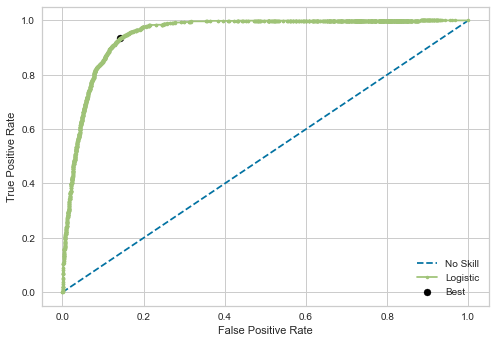

Best Threshold=0.266794, F-Score=0.642


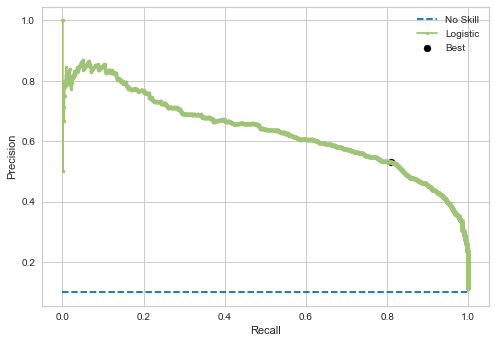

In [23]:
selecting_optimal_thresholds(model_rf,x_test,y_test)

[[1117   79]
 [1536 9262]]


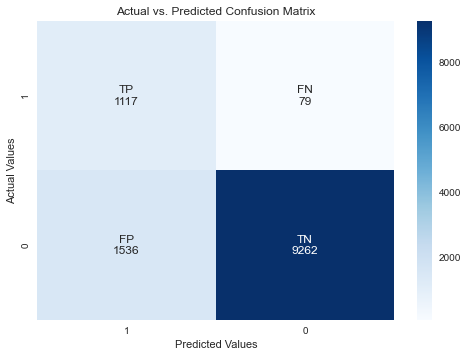

 TPR  => 0.9339464882943144 

 FPR  => 0.1422485645489906 

              precision    recall  f1-score   support

           1       0.42      0.93      0.58      1196
           0       0.99      0.86      0.92     10798

    accuracy                           0.87     11994
   macro avg       0.71      0.90      0.75     11994
weighted avg       0.93      0.87      0.89     11994



,Random Forest ROC
Accuracy,0.865349
Precision,0.421033
Recall,0.933946
F1 Score,0.580410
ROC AUC,0.895849


In [24]:
y_pred = (model_rf.predict_proba(x_test)[:,1] >= 0.129902).astype(bool) 
draw_confusion_matrix_binary(y_test,y_pred)
roc_metrix_rf = model_compare("Random Forest ROC ",model_rf, y_test, y_pred,True)
roc_metrix_rf

In [25]:
metrix_rf

,Random Forest
Accuracy,0.922128
Precision,0.638478
Recall,0.505017
F1 Score,0.563959
ROC AUC,0.736672


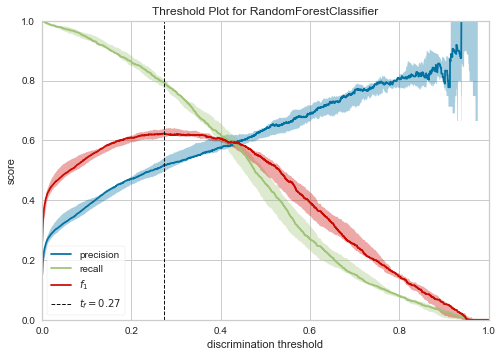

<AxesSubplot:title={'center':'Threshold Plot for RandomForestClassifier'}, xlabel='discrimination threshold', ylabel='score'>

In [49]:
visualizer = DiscriminationThreshold(model_rf,
                                     n_trials=5,
                                     cv=0.5,
                                     argmax='fscore',
                                     random_state=0,
                                     is_fitted=False,
                                     exclude = "queue_rate")

visualizer.fit(x_train, y_train)        # Fit the visualizer and the model
visualizer.score(x_test, y_test)        # Evaluate the model on the test data
visualizer.show()

[[ 959  237]
 [ 842 9956]]


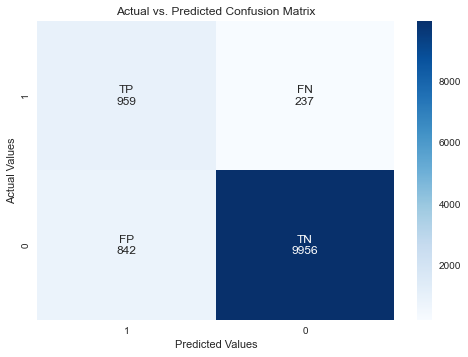

 TPR  => 0.8018394648829431 

 FPR  => 0.07797740322281899 

              precision    recall  f1-score   support

           1       0.53      0.80      0.64      1196
           0       0.98      0.92      0.95     10798

    accuracy                           0.91     11994
   macro avg       0.75      0.86      0.79     11994
weighted avg       0.93      0.91      0.92     11994



,Random Forest ROC
Accuracy,0.910038
Precision,0.532482
Recall,0.801839
F1 Score,0.639973
ROC AUC,0.861931


In [26]:
y_pred = (model_rf.predict_proba(x_test)[:,1] >= 0.27).astype(bool) 
draw_confusion_matrix_binary(y_test,y_pred)
fscore_metrix_rf = model_compare("Random Forest ROC ",model_rf, y_test, y_pred,True)
fscore_metrix_rf

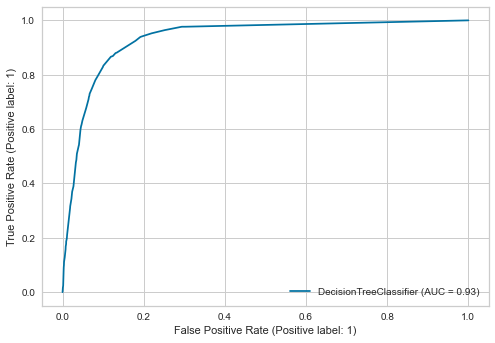

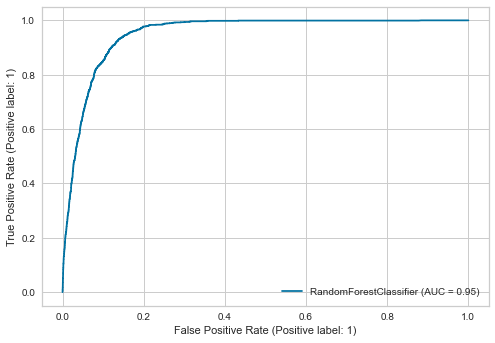

In [35]:
dt_roc_disp = plot_roc_curve(model_dt, x_test, y_test)
rf_roc_disp = plot_roc_curve(model_rf, x_test, y_test)

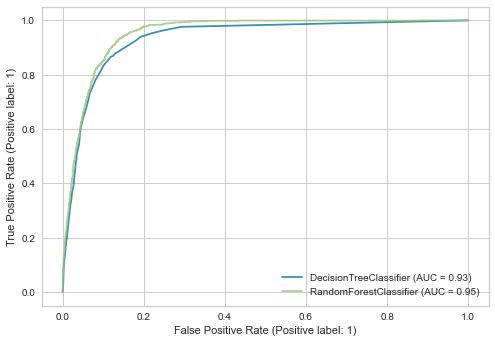

In [36]:
# Comparing which has the best ROC among the Models
ax = plt.gca()
dt_roc_disp.plot(ax=ax, alpha=0.8)
rf_roc_disp.plot(ax=ax, alpha=0.8)

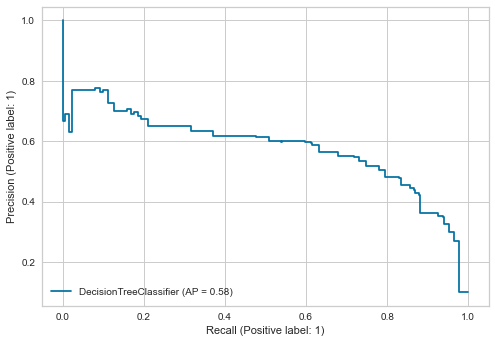

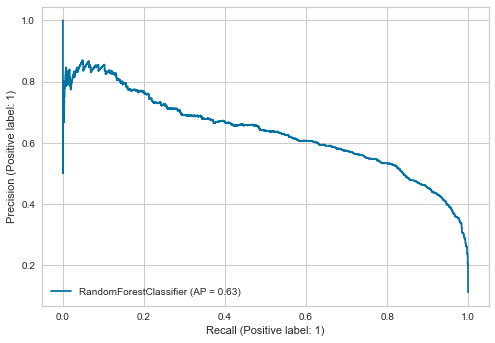

In [37]:
df_prc_disp = plot_precision_recall_curve(model_dt, x_test, y_test)
rf_prc_disp = plot_precision_recall_curve(model_rf, x_test, y_test)

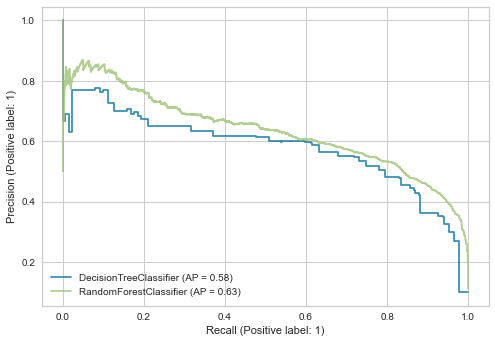

In [41]:
# Comparing which has the best PRC the Models
ax = plt.gca()
df_prc_disp.plot(ax=ax, alpha=0.8)
rf_prc_disp.plot(ax=ax, alpha=0.8)

In [27]:
metrics_bn_new = pd.concat([metrix_dt, roc_metrix_dt, metrix_rf, roc_metrix_rf], axis=1) #  metrix_nb,  metrix_GB, , metrix_xgboost
metrics_bn_new

,Decision Tree,Decision Tree ROC,Random Forest,Decision Tree ROC
Accuracy,0.918709,0.905286,0.922128,0.865349
Precision,0.613800,0.516611,0.638478,0.421033
Recall,0.498328,0.780100,0.505017,0.933946
F1 Score,0.550069,0.621586,0.563959,0.580410
ROC AUC,0.731800,0.849626,0.736672,0.895849


In [28]:
!pip install yellowbrick